# QF 627 Extras - Financial Analytics
## Lesson 4 | Causal Inference with Propensity Score `Matching` & Inverse Probability Weights (IPW)

> Hi, Team üëã Thank you for opening the script üôÇ

> Tonight, we will learn the fundamentals and advanced techniques of causal inference, a critical aspect of financial analytics that allows us to understand the causal effects in our data. By exploring various methods, we aim to equip you with the tools necessary to make informed decisions based on robust analytical frameworks.

## DEPENDENCIES

In [1]:
# Load libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

# Set print options

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

# Define our customized timer function

def countdown(Time):
    
    while Time:
        minutes, seconds = divmod(Time, 60)
        timer = "{:02d}:{:02d}".format(minutes, seconds)
        
        print(timer, end = "\r")
        time.sleep(1)
        Time -= 1
        
    print("Let us solve the problem above together :)")

## üëâ <a id = "top">Learning Pointers</a> üëà 

## [1. Propensity Score Matching (PSM)](#p1)

> ### <font color = red> The Essentials </font>

## [2. Further Learning on Matching and Propensity Score](#p2)

> ### <font color = red> Chapter 10 of *Causal Inference for the Brave and True* </font>

## [3. Further Learning on Matching and Propensity Score](#p3)

> ### <font color = red> Chapter 11 of *Causal Inference for the Brave and True*</font>

## [4. What We Learned & What's Next](#p4)

> ### <font color = red> Revisiting Learning Pointers </font>


## <a id = "p1">1.</a>  <font color = "green"> Propensity Score Matching (PSM) </font>  [back to table of contents](#top)

### Analytics Contexts

* Propensity score matching (PSM) is a statistical technique used to estimate the effect of a treatment or intervention when a randomized controlled experiment is not feasible. It is particularly useful with observational data, where treatment assignment is not random and is based on pre-existing characteristics. PSM helps create a synthetic control group that closely resembles the treatment group in terms of these characteristics, thus mimicking a randomized experiment and reducing selection bias.

    Causal Analytic Question in Hand: Estimating the Effect of Health Clinics on Infant Mortality

#### Scenario

> Suppose a non-governmental organization (NGO) has built health clinics in several villages. These villages were selected based on the program administrators' assessment of need, not randomly. We aim to estimate the effect of these health clinics on infant mortality rates using propensity score matching.

* Data Description

    - `Villages` (***N*** = 9): Each village is observed for the treatment and outcome.
    - `Treatment Variable` (`T`): Indicates whether a village received a health clinic (1) or not (0).
    - `Outcome Variable` (`IM rate`): Infant mortality rate, measured in deaths per thousand, a year after the clinics were established.
    - `Pre-Program Characteristics`: Poverty rates and the number of doctors per capita in each village before the program.

* Simple Comparison

> A simple comparison of the average infant mortality rate between treatment and control villages might suggest that clinics are increasing infant mortality. However, this is likely misleading due to the non-random assignment of clinics.

### Step-by-Step Propensity Score Matching Procedure

* Estimate Propensity Scores: Use logistic regression to estimate the probability (propensity score) that each village received a clinic based on pre-program characteristics (poverty rates and doctors per capita).

* Match Treatment and Control Villages: Match each treated village with one or more control villages based on similar propensity scores.

* Compare Outcomes: Compare the average infant mortality rate between the matched treatment and control groups to estimate the treatment effect.

### List of Variables

* `village`: Unique identifier for each village.

* `treatment`: Indicator variable for treatment status.
    - `1`: Village received `treatment`
    - `0`: Village did `not` receive treatment

* `poverty_rate`: Poverty rate in each village, expressed as a percentage.

* `doctors_per_capita`: Number of doctors per capita in each village.

* `infant_mortality_rate`: Infant mortality rate in each village, expressed as deaths per 1,000 live births.

In [2]:
# Synthetic Data

np.random.seed(2025)

# Model Parameters 

## Size of Unit of Analysis

N = 9

villages =\
(
    np
    .arange(1, N + 1) # unit of analysis ==> each village
)

## Treatment vs. Control ==> Explanatory Variable (X variable of interest)

treatment =\
(
    np
    .array([1,1,1,1,1, # treated
            0,0,0,0] # controlled
          )
)

## Response Variable (Y variable of interest)

infant_mortality_rate =\
(
    np
    .array([25, 27, 30, 25, 22,
            19, 20, 15, 17]
          )
)

## Confounders

poverty_rate =\
(
    np
    .array([55, 65, 50, 70, 65,
            50, 35, 25, 20]
          )
)

doctors_per_capita =\
(
    np
    .array([0.01, 0.02, 0.03, 0.01, 0.02,
            0.05, 0.04, 0.05, 0.04]
          )
)

In [3]:
%who

N	 countdown	 datetime	 doctors_per_capita	 infant_mortality_rate	 mpl	 np	 pd	 plt	 
poverty_rate	 re	 sm	 smf	 sns	 time	 treatment	 villages	 warnings	 



In [4]:
# Tabular Data ==> 2 dimensional data ==> DataFrame

data=\
(
    pd
    .DataFrame(
        {"village": villages,
         "treatment": treatment,
         "infant_mortality_rate": infant_mortality_rate,
         "doctors_per_capita": doctors_per_capita,
         "poverty_rate": poverty_rate
        }
    )
)

data

village  treatment  infant_mortality_rate  doctors_per_capita  poverty_rate
0        1          1                     25                0.01            55
1        2          1                     27                0.02            65
2        3          1                     30                0.03            50
3        4          1                     25                0.01            70
4        5          1                     22                0.02            65
5        6          0                     19                0.05            50
6        7          0                     20                0.04            35
7        8          0                     15                0.05            25
8        9          0                     17                0.04            20

### IMPORT

In [5]:
data

village  treatment  infant_mortality_rate  doctors_per_capita  poverty_rate
0        1          1                     25                0.01            55
1        2          1                     27                0.02            65
2        3          1                     30                0.03            50
3        4          1                     25                0.01            70
4        5          1                     22                0.02            65
5        6          0                     19                0.05            50
6        7          0                     20                0.04            35
7        8          0                     15                0.05            25
8        9          0                     17                0.04            20

In [6]:
from sklearn.linear_model import LogisticRegression

> We use logistic regression to estimate the propensity scores, representing the probability that a village received a health clinic based on pre-program characteristics.

In [7]:
data.columns

Index(['village', 'treatment', 'infant_mortality_rate', 'doctors_per_capita',
       'poverty_rate'],
      dtype='object')

In [8]:
# input features
confounders = data[['poverty_rate', 'doctors_per_capita']]

# outcome
outcome = data["treatment"]

# fit the logistic regression

logit = LogisticRegression()

(
    logit # using Logistic Regressor
    .fit(confounders, outcome) # fit() calculate
)

LogisticRegression()

In [9]:
(
    logit
    .predict_proba(confounders)[ : , 1]
) # probability of having clinic in the village, given that we know about the confounders

array([9.193e-01, 9.991e-01, 5.407e-01, 9.999e-01, 9.991e-01, 5.407e-01,
       1.301e-03, 1.394e-05, 1.442e-06])

In [10]:
data["propensity_scores"] =\
(
    logit
    .predict_proba(confounders)[ : , 1]
)

data

village  treatment  infant_mortality_rate  doctors_per_capita  \
0        1          1                     25                0.01   
1        2          1                     27                0.02   
2        3          1                     30                0.03   
3        4          1                     25                0.01   
4        5          1                     22                0.02   
5        6          0                     19                0.05   
6        7          0                     20                0.04   
7        8          0                     15                0.05   
8        9          0                     17                0.04   

   poverty_rate  propensity_scores  
0            55           0.919255  
1            65           0.999061  
2            50           0.540734  
3            70           0.999903  
4            65           0.999061  
5            50           0.540672  
6            35           0.001301  
7            25           0.000014  
8            20           0.000001

#### Match Treatment and Control Villages:

> We use the NearestNeighbors algorithm to find the closest control village for each treated village based on the propensity scores.

In [11]:
from sklearn.neighbors import NearestNeighbors # KNN ==> K-Nearest Neighbors

# Let's run matching based on propensity scores

treated_villages = data[data["treatment"] == 1]

controlled_villages = data[data["treatment"] == 0]

In [12]:
treated_villages

village  treatment  infant_mortality_rate  doctors_per_capita  \
0        1          1                     25                0.01   
1        2          1                     27                0.02   
2        3          1                     30                0.03   
3        4          1                     25                0.01   
4        5          1                     22                0.02   

   poverty_rate  propensity_scores  
0            55           0.919255  
1            65           0.999061  
2            50           0.540734  
3            70           0.999903  
4            65           0.999061

In [13]:
controlled_villages

village  treatment  infant_mortality_rate  doctors_per_capita  \
5        6          0                     19                0.05   
6        7          0                     20                0.04   
7        8          0                     15                0.05   
8        9          0                     17                0.04   

   poverty_rate  propensity_scores  
5            50           0.540672  
6            35           0.001301  
7            25           0.000014  
8            20           0.000001

In [14]:
# Let's use KNN

knn =\
(
    NearestNeighbors(n_neighbors = 1)
    .fit(controlled_villages[["propensity_scores"]] # []   ==> Series ==> 1d-array
                                                    # [[]] ==> DataFrame ==> 2d-array
        )
)

In [15]:
distances, indices =\
(
    knn
    .kneighbors(treated_villages[["propensity_scores"]]
               )
)

In [16]:
distances

array([[3.786e-01],
       [4.584e-01],
       [6.189e-05],
       [4.592e-01],
       [4.584e-01]])

In [17]:
matched_controlled_villages =\
(
    controlled_villages
    .iloc[indices
          .flatten()
          ]
)

matched_controlled_villages

village  treatment  infant_mortality_rate  doctors_per_capita  \
5        6          0                     19                0.05   
5        6          0                     19                0.05   
5        6          0                     19                0.05   
5        6          0                     19                0.05   
5        6          0                     19                0.05   

   poverty_rate  propensity_scores  
5            50           0.540672  
5            50           0.540672  
5            50           0.540672  
5            50           0.540672  
5            50           0.540672

#### Combine Matched Groups:

> We combine the treated villages with their matched control villages to create a new synthetic control group.

In [18]:
matched_data =\
(
    pd
    .concat([treated_villages, # team, you cannot directly compare treated and controlled villages (they are different in the first place)
             matched_controlled_villages]
           )
)

matched_data

village  treatment  infant_mortality_rate  doctors_per_capita  \
0        1          1                     25                0.01   
1        2          1                     27                0.02   
2        3          1                     30                0.03   
3        4          1                     25                0.01   
4        5          1                     22                0.02   
5        6          0                     19                0.05   
5        6          0                     19                0.05   
5        6          0                     19                0.05   
5        6          0                     19                0.05   
5        6          0                     19                0.05   

   poverty_rate  propensity_scores  
0            55           0.919255  
1            65           0.999061  
2            50           0.540734  
3            70           0.999903  
4            65           0.999061  
5            50           0.540672  
5            50           0.540672  
5            50           0.540672  
5            50           0.540672  
5            50           0.540672

#### Estimate Treatment Effect:

> We compare the average infant mortality rate in the treated group with the average in the new matched control group to estimate the effect of the health clinics.

In [19]:
(
    treated_villages["infant_mortality_rate"].mean()
    -
    controlled_villages["infant_mortality_rate"].mean()
)

np.float64(8.05)

In [20]:
average_treatment_effect =\
(
    treated_villages["infant_mortality_rate"].mean()
    -
    matched_controlled_villages["infant_mortality_rate"].mean()
)

average_treatment_effect

np.float64(6.800000000000001)

### Assessing the Matching Quality (Recall that we discussed about `post-hoc` `randomization` checks)

> To ensure the validity of our matching, we should:

* `Compare Distributions`: Check that the distributions of pre-program characteristics in the matched control group are similar to those in the treatment group.

* `Compare Propensity Scores`: Ensure the distributions of propensity scores in the treatment and matched control groups are similar.

* `Check Overlap`: Verify that there is sufficient overlap in propensity scores between the treatment and original control groups.

### Advantages and Disadvantages of PSM

#### Advantages:

* `Less Sensitive to Functional Form`: Unlike regression, PSM does not require specifying a functional form for the covariates.

* `Clear Assessment`: It's straightforward to assess the quality of matching by comparing covariate distributions and propensity scores.

* `Ignore Irrelevant Controls`: PSM can ignore control observations that are very different from the treated observations.

#### Disadvantages:

* `Binary Treatment`: PSM is designed for binary treatments and may not easily handle treatments with varying intensities.

* `No Information on Other Covariates`: PSM focuses on the treatment effect and does not provide information about the effect of other covariates.

* `Arbitrary Decisions`: There are many ways to implement PSM, and different decisions can affect results.

> `Propensity score matching` (`PSM`) is a useful technique for estimating treatment effects in observational studies. It helps create a synthetic control group that mimics a randomized experiment by balancing pre-treatment characteristics between treated and control groups.

> However, it has `limitations` and does not address issues related to unobserved confounders, which require different methods like `difference-in-differences` or `instrumental variables`.

## <mark> Comparing Methods of Matching for Causal Inference without RCTs </mark>

### Analytic Contexts

> Here's a causal analytics question at hand: government officers are interested in whether using mosquito nets decreases an individual‚Äôs risk of contracting dengue.

> They have collected data from 1,752 households in an unnamed country, including variables related to environmental factors, individual health, and household characteristics.

> The data is not collected based on randomized controlled trials‚Äî-the policymakers have no control over who uses mosquito nets. Individual households make their own choices about whether to apply for free nets, buy their own nets, and whether they use the nets if they have them.

### Data set

> The dataset contains the following columns:

* Dengue risk (`dengue_risk`): The likelihood that someone in the household will be infected with dengue. Measured on a scale of 0‚Äì100, with higher values indicating higher risk.

* Mosquito net (`net` and `net_num`): A binary variable indicating if the household used mosquito nets.

* Eligible for program (`eligible`): A binary variable indicating if the household is eligible for the free net program.

* Income (`income`): The household‚Äôs monthly income, in US dollars.

* Nighttime temperatures (`temperature`): The average temperature at night, in Celsius.

* Health (`health`): Self-reported healthiness in the household. Measured on a scale of 0‚Äì100, with higher values indicating better health.

* Number in household (`household`): Number of people living in the household.
  
* Insecticide resistance (`resistance`): Some strains of mosquitoes are more resistant to insecticide and thus pose a higher risk of infecting people with dengue. This is measured on a scale of 0‚Äì100, with higher values indicating higher resistance.

### Our Goal

> Our goal in this analytic task is to estimate the causal effect of bed net usage on dengue risk using only observational data. This was not an RCT, so it might seem a little sketchy to make claims of causality. But if we can draw a correct DAG and adjust for the correct nodes, we can isolate the net ‚Üí dengue relationship and talk about causality.

> Because this is simulated data, we know the true causal effect of the net program because it was built into the data. The true average treatment effect (ATE) is -10. Using a mosquito net causes the risk of dengue to decrease by 10 points, on average.

> Let's see if we can find that `10 point effect`!

### Additional Dependencies

In [21]:
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.weightstats import DescrStatsW

# Set seed for reproducibility
np.random.seed(2025)

### Import

In [22]:
net =\
(
    pd
    .read_csv("https://talktoroh.squarespace.com/s/dengue-5nsp.csv")
)

In [23]:
net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1752 non-null   int64  
 1   net          1752 non-null   bool   
 2   net_num      1752 non-null   int64  
 3   dengue_risk  1752 non-null   int64  
 4   income       1752 non-null   int64  
 5   health       1752 non-null   int64  
 6   household    1752 non-null   int64  
 7   eligible     1752 non-null   bool   
 8   temperature  1752 non-null   float64
 9   resistance   1752 non-null   int64  
dtypes: bool(2), float64(1), int64(7)
memory usage: 113.1 KB


### Wrangle

In [24]:
net.dtypes

id               int64
net               bool
net_num          int64
dengue_risk      int64
income           int64
health           int64
household        int64
eligible          bool
temperature    float64
resistance       int64
dtype: object

In [25]:
net["dengue_risk"] = net["dengue_risk"].astype(float)

net["income"] = net["income"].astype(float)

net["temperature"] = net["temperature"].astype(float)

In [26]:
net.dtypes

id               int64
net               bool
net_num          int64
dengue_risk    float64
income         float64
health           int64
household        int64
eligible          bool
temperature    float64
resistance       int64
dtype: object

### Naive Correlation-Isn't-Causation Estimate

> First, let‚Äôs calculate the naive estimate of the effect of mosquito net usage on dengue risk:

In [27]:
naive_est_of_causal_effect =\
(
    net
    .groupby("net")
    .dengue_risk
    .mean()
)

naive_est_of_causal_effect.to_frame()

dengue_risk
net               
False    41.936508
True     25.604993

In [28]:
import statsmodels.formula.api as smf

In [29]:
model_naive =\
(
    smf
    .ols(formula = "dengue_risk ~ net",
         data = net)
    .fit()
)

model_naive\
    .summary()\
    .tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

> We group the data by the net column and calculate the mean dengue_risk for each group.

> We then perform a simple linear regression to estimate the effect of net on `dengue_risk` without adjusting for any confounders.

### `PURE` Matching => using `covariates`

> Matching helps us control for confounding variables by pairing observations with similar values of the confounders.

In [30]:
net.columns

Index(['id', 'net', 'net_num', 'dengue_risk', 'income', 'health', 'household',
       'eligible', 'temperature', 'resistance'],
      dtype='object')

In [31]:
# Step 1: Identify Confounders

confounders = ['income', 'health', 'temperature'] # confounders identified

In [32]:
net[confounders] # the variables are on different scales

income  health  temperature
0      781.0      56         21.1
1      974.0      57         26.5
2      502.0      15         25.6
3      671.0      20         21.3
4      728.0      17         19.2
...      ...     ...          ...
1747   961.0      27         22.1
1748   906.0      49         30.7
1749  1325.0      92         21.4
1750   879.0      33         27.4
1751  1339.0      77         27.7

[1752 rows x 3 columns]

In [33]:
%whos

Variable                      Type                        Data/Info
-------------------------------------------------------------------
DescrStatsW                   type                        <class 'statsmodels.stats<...>weightstats.DescrStatsW'>
GLM                           type                        <class 'statsmodels.genmo<...>alized_linear_model.GLM'>
LogisticRegression            type                        <class 'sklearn.linear_mo<...>stic.LogisticRegression'>
N                             int                         9
NearestNeighbors              ABCMeta                     <class 'sklearn.neighbors<...>rvised.NearestNeighbors'>
StandardScaler                type                        <class 'sklearn.preproces<...>ng._data.StandardScaler'>
average_treatment_effect      float64                     6.800000000000001
confounders                   list                        n=3
controlled_villages           DataFrame                      village  treatment  in<...>  20    

In [34]:
# from sklearn.preprocessing import StandardScaler

In [35]:
# Step 2: Standardize the Scale of Confounders

                          # mean-centering; scaling
scaler = StandardScaler() # set means at 0; set SDs at 1

scaled_confounders =\
(
    scaler
    .fit_transform(net[confounders]
                  )
    # .fit() calculates
    # .transform() implements
    # .fit_transform()
)

In [36]:
# Step 3: Matching with Propensity Scoring

KNN = NearestNeighbors(n_neighbors = 1)

(
    KNN
    .fit(scaled_confounders)
)

dist, ids =\
(
    KNN
    .kneighbors(scaled_confounders)
)

In [37]:
# Step 4: Obtain comparable dataset (mathched dataset)

matched_ids =\
(
    ids
    .flatten()
)

matched_data =\
(
    net
    .loc[matched_ids]
)

In [38]:
matched_data

id    net  net_num  dengue_risk  income  health  household  eligible  \
0        1   True        1         33.0   781.0      56          2     False   
1        2  False        0         42.0   974.0      57          4     False   
2        3  False        0         80.0   502.0      15          3     False   
3        4   True        1         34.0   671.0      20          5      True   
4        5  False        0         44.0   728.0      17          5     False   
...    ...    ...      ...          ...     ...     ...        ...       ...   
1747  1748   True        1         18.0   961.0      27          4     False   
1748  1749  False        0         49.0   906.0      49          5     False   
1749  1750  False        0         17.0  1325.0      92          2     False   
1750  1751  False        0         46.0   879.0      33          6     False   
1751  1752   True        1         13.0  1339.0      77          4     False   

      temperature  resistance  
0            21.1          59  
1            26.5          73  
2            25.6          65  
3            21.3          46  
4            19.2          54  
...           ...         ...  
1747         22.1          27  
1748         30.7          55  
1749         21.4          52  
1750         27.4          62  
1751         27.7          44  

[1752 rows x 10 columns]

In [39]:
# Step 5: Run Regression Equation with Matched Data (propensity scoring with covariates)

model_with_psm =\
(
    smf
    .ols(formula = "dengue_risk ~ net",
         data = matched_data)
    .fit()
)

model_with_psm\
    .summary()\
    .tables[0]

<class 'statsmodels.iolib.table.SimpleTable'>

> The Steps Revisited

* Identify the confounders and standardize them to ensure they are on the same scale.

* Use the Nearest Neighbors algorithm to find the closest matches based on the confounders.

* Create a matched dataset by selecting only the matched observations.

* Perform a regression analysis on the matched dataset.

### Inverse Probability Weighting (`IPW`)

> Inverse Probability Weighting adjusts for confounders by assigning weights to each observation based on the probability of receiving the treatment.

#### let's run logistic regression for calculating propensity score

In [40]:
%who

DescrStatsW	 GLM	 KNN	 LogisticRegression	 N	 NearestNeighbors	 StandardScaler	 average_treatment_effect	 confounders	 
controlled_villages	 countdown	 data	 datetime	 dist	 distances	 doctors_per_capita	 families	 ids	 
indices	 infant_mortality_rate	 knn	 logit	 matched_controlled_villages	 matched_data	 matched_ids	 model_naive	 model_with_psm	 
mpl	 naive_est_of_causal_effect	 net	 np	 outcome	 pd	 plt	 poverty_rate	 re	 
scaled_confounders	 scaler	 sm	 smf	 sns	 time	 treated_villages	 treatment	 villages	 
warnings	 


In [41]:
LOGIT = LogisticRegression()

         # input features, outcome
LOGIT.fit(net[confounders], net["net"]
         )

LogisticRegression()

#### let's obtain PS

In [42]:
net["propensity"] =\
(
    LOGIT
    .predict_proba(net[confounders]
                  )
    [ : , 1] # take all the observation, take just second column
)

net.head(10)

id    net  net_num  dengue_risk  income  health  household  eligible  \
0   1   True        1         33.0   781.0      56          2     False   
1   2  False        0         42.0   974.0      57          4     False   
2   3  False        0         80.0   502.0      15          3     False   
3   4   True        1         34.0   671.0      20          5      True   
4   5  False        0         44.0   728.0      17          5     False   
5   6  False        0         25.0  1050.0      48          1     False   
6   7   True        1         19.0  1146.0      65          3     False   
7   8  False        0         35.0  1093.0      75          5     False   
8   9  False        0         32.0  1037.0      60          3     False   
9  10  False        0         40.0   828.0      36          3     False   

   temperature  resistance  propensity  
0         21.1          59    0.367393  
1         26.5          73    0.388961  
2         25.6          65    0.158101  
3         21.3          46    0.262629  
4         19.2          54    0.307791  
5         25.3          34    0.429374  
6         27.4          45    0.477326  
7         29.8          65    0.431976  
8         27.6          55    0.409909  
9         21.3          54    0.355554

> One potential downside to traditional matching techniques is that they often require discarding a significant portion of your data‚Äîanything that doesn‚Äôt find a match is excluded from the final matched dataset.

> A distinct alternative to conventional propensity score matching with logistic regression is to employ `inverse probability weighting` (`IPW`).

> Instead of matching observations, this method involves calculating the probability of receiving treatment for each observation and then assigning weights based on the inverse of these probabilities. Observations that defy expectations‚Äîthose predicted to receive treatment but don‚Äôt, or those predicted not to receive treatment but do‚Äîare given higher weights compared to those that align with predictions.

> The process of generating these inverse probability weights involves two main steps:

* (1) `calculating propensity scores`, which represent the probability of receiving treatment, and
* (2) `transforming these propensity scores` into `weights` using a specific formula.

> Once these inverse probability weights are calculated, they can be incorporated into the regression model to achieve a more balanced and representative analysis without the need to discard unmatched data.

![](https://talktoroh.squarespace.com/s/ipw.png)

### IPW

> Let's calculate `I`nverse `P`robability `W`eights

In [43]:
net["ipw"] =\
(
    (net["net"]
     /
     net["propensity"] # predicted probability of having mosquito net in household
    )
        + 
    (
        (1 - net["net"])
        /
        (1 - net["propensity"])
    )
)

In [44]:
net[["id", "net", "dengue_risk", "propensity", "ipw"]]

id    net  dengue_risk  propensity       ipw
0        1   True         33.0    0.367393  2.721879
1        2  False         42.0    0.388961  1.636556
2        3  False         80.0    0.158101  1.187792
3        4   True         34.0    0.262629  3.807653
4        5  False         44.0    0.307791  1.444650
...    ...    ...          ...         ...       ...
1747  1748   True         18.0    0.395028  2.531465
1748  1749  False         49.0    0.289918  1.408288
1749  1750  False         17.0    0.694572  3.274092
1750  1751  False         46.0    0.295678  1.419805
1751  1752   True         13.0    0.593104  1.686046

[1752 rows x 5 columns]

## Run Weighted Least Squares

In [45]:
model_using_IPW =\
(
    smf
    .wls(formula = "dengue_risk ~ net",
         data = net,
         weights = net["ipw"]
        )
    .fit()
)

model_using_IPW\
    .summary()\
    .tables[1] # YAY!

<class 'statsmodels.iolib.table.SimpleTable'>

> Steps Revisited

* Use logistic regression to model the probability of using a mosquito net (propensity score) based on the confounders.

* Calculate the inverse probability weights for each observation.

* Perform a weighted regression using these weights to estimate the causal effect of mosquito net usage on dengue risk.

### Comparison of Models (Sensitivity Analysis)

In [46]:
from stargazer.stargazer import Stargazer

In [47]:
%who

DescrStatsW	 GLM	 KNN	 LOGIT	 LogisticRegression	 N	 NearestNeighbors	 StandardScaler	 Stargazer	 
average_treatment_effect	 confounders	 controlled_villages	 countdown	 data	 datetime	 dist	 distances	 doctors_per_capita	 
families	 ids	 indices	 infant_mortality_rate	 knn	 logit	 matched_controlled_villages	 matched_data	 matched_ids	 
model_naive	 model_using_IPW	 model_with_psm	 mpl	 naive_est_of_causal_effect	 net	 np	 outcome	 pd	 
plt	 poverty_rate	 re	 scaled_confounders	 scaler	 sm	 smf	 sns	 time	 
treated_villages	 treatment	 villages	 warnings	 


In [48]:
# build Stargazer object

three_models =\
    Stargazer([model_naive, model_with_psm, model_using_IPW]
             )

In [49]:
# Getting rid of noise in your understanding of model (here, R-squared does not carry meaning)

three_models.show_r2 = False
three_models.show_adj_r2 = False

In [50]:
# Add title to the each model

three_models\
    .custom_columns(["Naive Est.", "Matching with Covariates", "Inverse Probability Weights"],
                    [1, 1, 1]
                   )

In [51]:
from IPython.display import HTML, display

In [52]:
html =\
(
    three_models
    .render_html()
)

In [53]:
html

'<table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr>\n<tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable: dengue_risk</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Naive Est.</td><td colspan="1">Matching with Covariates</td><td colspan="1">Inverse Probability Weights</td></tr><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td></tr>\n<tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr>\n\n<tr><td style="text-align:left">Intercept</td><td>41.937<sup>***</sup></td><td>41.937<sup>***</sup></td><td>39.679<sup>***</sup></td></tr>\n<tr><td style="text-align:left"></td><td>(0.405)</td><td>(0.405)</td><td>(0.468)</td></tr>\n<tr><td style="text-align:left">net[T.True]</td><td>-16.332<sup>***</sup></td><td>-16.332<sup>***</sup></td><td>-10.132<sup>***</sup></td></tr>\n<tr><td style="text-align:left"></td><td>(0.649)</td><td>(0.649)</td><td>(0.658)</t

In [54]:
display(HTML(html)
       )

### For `experimentation`

### For `documentation`

### IMPORTANT: 

    How do we know what we do not know in the first place? 
    
    One approach in analytics is to run simulations with synthetic data--yay!

## <a id = "p2">2.</a>  <font color = "green"> Further Learning on Matching </font>  [back to table of contents](#top)

## Chapter 10 from Textbook | `Matching`

## What is Regression Doing After All?

As we've seen so far, regression does an amazing job at controlling for additional variables when we do a test vs control comparison. If we have independence, $(Y_0, Y_1)\perp T | X$, then regression can identify the ATE by controlling for X. The way regression does this is kind of magical. To get some intuition about it, let's remember the case when all variables X are dummy variables. If that is the case, regression partitions the data into the dummy cells and computes the mean difference between test and control. This difference in means keeps the Xs constant, since we are doing it in a fixed cell of X dummy. It is as if we were doing $E[Y|T=1] - E[Y|T=0] | X=x$, where $x$ is a dummy cell (all dummies set to 1, for example).  Regression then combines the estimate in each of the cells to produce a final ATE. The way it does this is by applying weights to the cell proportional to the variance of the treatment on that group. 

To give an example, let's suppose I'm trying to estimate the effect of a drug and I have 6 men and 4 women. My response variable is days hospitalised and I hope my drug can lower that. On men, the true causal effect is -3, so the drug lowers the stay period by 3 days. On women, it is -2. To make matters more interesting, men are much more affected by this illness and stay longer at the hospital. They also get much more of the drug. Only 1 out of the 6 men does not get the drug. On the other hand, women are more resistant to this illness, so they stay less at the hospital. 50% of the women get the drug.

In [55]:
drug_example =\
(
    pd
    .DataFrame(dict(
        sex= ["M","M","M","M","M","M", "W","W","W","W"],
        drug=[1,1,1,1,1,0,  1,0,1,0],
        days=[5,5,5,5,5,8,  2,4,2,4]
                    )
              )
)

Note that simple comparison of treatment and control yields a negatively biased effect, that is, the drug seems less effective than it truly is. This is expected, since we've omitted the sex confounder. In this case, the estimated ATE is smaller than the true one because men get more of the drug and are more affected by the illness. 

In [56]:
drug_example.query("drug==1")["days"].mean() - drug_example.query("drug==0")["days"].mean()

np.float64(-1.1904761904761898)

Since the true effect for man is -3 and the true effect for woman is -2, the ATE should be

$
ATE=\dfrac{(-3*6) + (-2*4)}{10}=-2.6
$

This estimate is done by 1) partitioning the data into confounder cells, in this case, man and women, 2) estimating the effect on each cell and 3) combining the estimate with a weighted average, where the weight is the sample size of the cell or covariate group. If we had exactly the same size of man and woman in the data, the ATE estimate would be right in the middle of the ATE of the 2 groups, -2.5. Since there are more men than women in our dataset, the ATE estimate is a little bit closer to the man's ATE. This is called a non-parametric estimate, since it places no assumption on how the data was generated.

If we control for sex using regression, we will add the assumption of linearity. Regression will also partition the data into man and woman and estimate the effect on both of these groups. So far, so good. However, when it comes to combining the effect on each group, it does not weigh them by the sample size. Instead, regression uses weights that are proportional to the variance of the treatment in that group. In our case, the variance of the treatment in men is smaller than in women, since only one man is in the control group. To be exact, the variance of T for man is $0.139=1/6*(1 - 1/6)$ and for women is $0.25=2/4*(1 - 2/4)$. So regression will give a higher weight to women in our example and the ATE will be a bit closer to the women's ATE of -2.

In [57]:
smf.ols('days ~ drug + C(sex)', data=drug_example).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

This result is more intuitive with dummy variables, but, in its own weird way, regression also keeps continuous variables constant while estimating the effect. Also with continuous variables, the ATE will point in the direction where covariates have more variance. 

So we've seen that regression has its idiosyncrasies. It is linear, parametric, likes high variance features... This can be good or bad, depending on the context. Because of this, it's important to be aware of other techniques we can use to control for confounders. Not only are they an extra tool in your causal tool belt, but understanding different ways to deal with confounding expands our understanding of the problem. For this reason, I present you now the **Subclassification Estimator!**


## The Subclassification Estimator
If there is some causal effect we want to estimate, like the effect of job training on earnings, **and** the treatment is not randomly assigned, we need to watch out for confounders. It could be that only more motivated people do the training and they would have higher earnings regardless of the training. We need to estimate the effect of the training program within small groups of individuals that are roughly the same in motivation level and any other confounders we may have.

More generally, if there is some causal effect we want to estimate, but it is hard to do so because of confounding of some variables X, what we need to do is make the treatment vs control comparison within small groups where X is the same. If we have conditional independence $(Y_0, Y_1)\perp T | X$, then we can write the ATE as follows.

$
ATE = \int(E[Y|X, T=1] - E[Y|X, T=0])dP(x)
$

What this integral does is it goes through all the space of the distribution of features X, computes the difference in means for all those tiny spaces and combines everything into the ATE. Another way to see this is to think about a discrete set of features. In this case, we can say that the features X takes on K different cells $\{X_1, X_2, ..., X_k\}$ and what we are doing is computing the treatment effect in each cell and combining them into the ATE. In this discrete case, converting the integral to a sum, we can derive the subclassifications estimator


$
\hat{ATE} = \sum^K_{i=1}(\bar{Y}_{k1} - \bar{Y}_{k0}) * \dfrac{N_k}{N}
$

where the bar represent the mean of the outcome on the treated, $Y_{k1}$, and non-treated, $Y_{k0}$, at cell k and $N_{k}$ is the number of observations in that same cell. As you can see, we are computing a local ATE for each cell and combining them using a weighted average, where the weights are the sample size of the cell. In our medicine example above, this would be the first estimate, which gave us ‚àí2.6.

## Matching Estimator
The subclassification estimator isn't used much in practice (we will see why shortly, it is because of the curse of dimensionality) but it gives us a nice intuition of what a causal inference estimator should do, how it should control for confounders. This allows us to explore other kinds of estimators, such as the Matching Estimator. 

The idea is very similar. Since some sort of confounder X makes it so that treated and untreated are not initially comparable, I can make them so by **matching each treated unit with a similar untreated unit**. It is like I'm finding an untreated twin for every treated unit. By making such comparisons, treated and untreated become again comparable. 

As an example, let's suppose we are trying to estimate the effect of a trainee program on earnings. Here is what the trainees looks like

In [58]:
trainee = pd.read_csv("https://talktoroh.squarespace.com/s/trainees.csv")
trainee.query("trainees==1")

unit  trainees  age  earnings
0      1         1   28     17700
1      2         1   34     10200
2      3         1   29     14400
3      4         1   25     20800
4      5         1   29      6100
5      6         1   23     28600
6      7         1   33     21900
7      8         1   27     28800
8      9         1   31     20300
9     10         1   26     28100
10    11         1   25      9400
11    12         1   27     14300
12    13         1   29     12500
13    14         1   24     19700
14    15         1   25     10100
15    16         1   43     10700
16    17         1   28     11500
17    18         1   27     10700
18    19         1   28     16300

And here are the non-trainees:

In [59]:
trainee.query("trainees==0")

unit  trainees  age  earnings
19    20         0   43     20900
20    21         0   50     31000
21    22         0   30     21000
22    23         0   27      9300
23    24         0   54     41100
24    25         0   48     29800
25    26         0   39     42000
26    27         0   28      8800
27    28         0   24     25500
28    29         0   33     15500
29    31         0   26       400
30    32         0   31     26600
31    33         0   26     16500
32    34         0   34     24200
33    35         0   25     23300
34    36         0   24      9700
35    37         0   29      6200
36    38         0   35     30200
37    39         0   32     17800
38    40         0   23      9500
39    41         0   32     25900

If I do a simple comparison in means, we get that the trainees earn less money than those that didn't go through the program.

In [60]:
trainee.query("trainees==1")["earnings"].mean() - trainee.query("trainees==0")["earnings"].mean()

np.float64(-4297.49373433584)

However, if we look at the table above, we notice that trainees are much younger than non trainees, which indicates that age is probably a confounder. Let's use matching on age to try to correct that. We will take unit 1 from the treated and pair it with unit 27, since both are 28 years old. Unit 2 we will pair it with unit 34, unit 3 with unit 37, unit 4 we will pair it with unit 35... When it comes to unit 5, we need to find someone with age 29 from the non treated, but that is unit 37, which is already paired. This is not a problem, since we can use the same unit multiple times. If more than 1 unit is a match, we can choose randomly between them. 

This is what the matched dataset looks like for the first 7 units

In [61]:
# make dataset where no one has the same age
unique_on_age = (trainee
                 .query("trainees==0")
                 .drop_duplicates("age"))

matches = (trainee
           .query("trainees==1")
           .merge(unique_on_age, on="age", how="left", suffixes=("_t_1", "_t_0"))
           .assign(t1_minuts_t0 = lambda d: d["earnings_t_1"] - d["earnings_t_0"]))

matches.head(7)

unit_t_1  trainees_t_1  age  earnings_t_1  unit_t_0  trainees_t_0  \
0         1             1   28         17700        27             0   
1         2             1   34         10200        34             0   
2         3             1   29         14400        37             0   
3         4             1   25         20800        35             0   
4         5             1   29          6100        37             0   
5         6             1   23         28600        40             0   
6         7             1   33         21900        29             0   

   earnings_t_0  t1_minuts_t0  
0          8800          8900  
1         24200        -14000  
2          6200          8200  
3         23300         -2500  
4          6200          -100  
5          9500         19100  
6         15500          6400

Notice how the last column has the difference in earnings between the treated and its matched untreated unit. If we take the mean of this last column we get the ATET estimate while controlling for age. Notice how the estimate is now very positive, compared to the previous one where we used a simple difference in means.

In [62]:
matches["t1_minuts_t0"].mean()

np.float64(2457.8947368421054)

But this was a very contrived example, just to introduce matching. In reality, we usually have more than one feature and units don't match perfectly. In this case, we have to define some measurement of proximity to compare how units are close to each other. One common metric for this is the euclidean norm $||X_i - X_j||$. This difference, however, is not invariant to the scale of the features. This means that features like age, that take values on the tenths, will be much less important when computing this norm compared to features like income, which take the order of hundreds. For this reason, before applying the norm, we need to scale the features so that they are on roughly the same scale.

Having defined a distance measure, we can now define the match as the nearest neighbour to that sample we wish to match. In math terms, we can write the matching estimator the following way

$
\hat{ATE} = \frac{1}{N} \sum^N_{i=1} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)
$

Where $Y_{jm}(i)$ is the sample from the other treatment group which is most similar to $Y_i$. We do this $2T_i - 1$ to match both ways: treated with controls and controls with the treatment. 

To test this estimator, let's consider a medicine example. Once again, we want to find the effect of a medication on days until recovery. Unfortunately, this effect is confounded by severity, sex and age. We have reasons to believe that patients with more severe conditions have a higher chance of receiving the medicine.

In [63]:
med = pd.read_csv("https://talktoroh.squarespace.com/s/medicine_impact_recovery.csv")
med.head()

sex        age  severity  medication  recovery
0    0  35.049134  0.887658           1        31
1    1  41.580323  0.899784           1        49
2    1  28.127491  0.486349           0        38
3    1  36.375033  0.323091           0        35
4    0  25.091717  0.209006           0        15

If we look at a simple difference in means, $E[Y|T=1]-E[Y|T=0]$, we get that the treatment takes, on average, 16.9 more days to recover than the untreated. This is probably due to confounding, since we don't expect the medicine to cause harm to the patient.

In [64]:
med.query("medication==1")["recovery"].mean() - med.query("medication==0")["recovery"].mean()

np.float64(16.895799546498726)

To correct for this bias, we will control for X using matching. First, we need to remember to scale our features, otherwise, features like age will have higher importance than features like severity when we compute the distance between points. To do so, we can standardise the features.

In [65]:
# scale features
X = ["severity", "age", "sex"]
y = "recovery"

med = med.assign(**{f: (med[f] - med[f].mean())/med[f].std() for f in X})
med.head()

sex       age  severity  medication  recovery
0 -0.996980  0.280787  1.459800           1        31
1  1.002979  0.865375  1.502164           1        49
2  1.002979 -0.338749  0.057796           0        38
3  1.002979  0.399465 -0.512557           0        35
4 -0.996980 -0.610473 -0.911125           0        15

Now, to the matching itself. Instead of coding a matching function, we will use the K nearest neighbour algorithm from [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). This algorithm makes predictions by finding the nearest data point in an estimation or training set. 

For matching, we will need 2 of those. One, `mt0`, will store the untreated points and will find matches in the untreated when asked to do so. The other, `mt1`, will store the treated point and will find matches in the treated when asked to do so. After this fitting step, we can use these KNN models to make predictions, which will be our matches.

In [66]:
from sklearn.neighbors import KNeighborsRegressor

treated = med.query("medication==1")
untreated = med.query("medication==0")

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[y])

predicted = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[X])),
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[X]))
])

predicted.head()

sex       age  severity  medication  recovery  match
0  -0.996980  0.280787  1.459800           1        31   39.0
1   1.002979  0.865375  1.502164           1        49   52.0
7  -0.996980  1.495134  1.268540           1        38   46.0
10  1.002979 -0.106534  0.545911           1        34   45.0
16 -0.996980  0.043034  1.428732           1        30   39.0

With the matches, we can now apply the matching estimator formula

$
\hat{ATE} = \frac{1}{N} \sum^N_{i=1} (2T_i - 1)\big(Y_i - Y_{jm}(i)\big)
$

In [67]:
np.mean((2*predicted["medication"] - 1)*(predicted["recovery"] - predicted["match"]))

np.float64(-0.9954)

Using this sort of matching, we can see that the effect of the medicine is not positive anymore. This means that, controlling for X, the medicine reduces the recovery time by about 1 day, on average. This is already a huge improvement on top of the biased estimate that predicted a 16.9 increase in recovery time. 

However, we can still do better.

## Matching Bias

It turns out the matching estimator as we've designed above is biased. To see this, let's consider the ATET estimator, instead of the ATE, just because it is simpler to write. The intuition will apply to the ATE as well.

$
\hat{ATET} = \frac{1}{N_1}\sum (Y_i - Y_j(i))
$

where $N_1$ is the number of treated individuals and $Y_j(i)$ is the untreated match of treated unit i. To check for bias, what we do is hope we can apply the Central Limit Theorem so that this down there converges to a normal distribution with mean zero. 

$
\sqrt{N_1}(\hat{ATET} - ATET)
$

However, this doesn't always happen. If we define the mean outcome for the untreated given X, $\mu_0(x)=E[Y|X=x, T=0]$, we will have that (btw, I've omitted the proof for that because it's a little beyond the point here).

$
E[\sqrt{N_1}(\hat{ATET} - ATET)] = E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))]
$

Now, $\mu_0(X_i) - \mu_0(X_j(i))$ is not so simple to understand, so let's look at it more carefully. $\mu_0(X_i)$ is the outcome Y value of a treated unit $i$ had it not been treated. So, it is the counterfactual outcome $Y_0$ for unit i. $\mu_0(X_j(i))$ is the outcome of the untreated unit $j$ that is the match of unit $i$. So, it is also the $Y_0$ , but for unit $j$ now. Only this time, it is a factual outcome, because $j$ is in the non treated group. Now, because $j$ and $i$ are only similar, but not the same, this will likely not be zero. In other words, $X_i \approx X_j $. So, $Y_{0i} \approx Y_{0j} $. 

As we increase the sample size, there will be more units to match, so the difference between unit $i$ and its match $j$ will also get smaller. But this difference converges to zero slowly. As a result $E[\sqrt{N_1}(\mu_0(X_i) - \mu_0(X_j(i)))]$ may not converge to zero, because the $\sqrt{N_1}$ grows faster than $(\mu_0(X_i) - \mu_0(X_j(i)))$ diminishes.

Bias arises when the matching discrepancies are huge. Fortunately, we know how to correct it. Each observation contributes $(\mu_0(X_i) - \mu_0(X_j(i)))$ to the bias so all we need to do is subtract this quantity from each matching comparison in our estimator. To do so, we can replace $\mu_0(X_j(i))$ with some sort of estimate of this quantity $\hat{\mu_0}(X_j(i))$, which can be obtained with models like linear regression. This updates the ATET estimator to the following equation

$
\hat{ATET} = \frac{1}{N_1}\sum \big((Y_i - Y_{j(i)}) - (\hat{\mu_0}(X_i) - \hat{\mu_0}(X_{j(i)}))\big)
$

where $\hat{\mu_0}(x)$ is some estimative of $E[Y|X, T=0]$, like a linear regression fitted only on the untreated sample.

In [68]:
from sklearn.linear_model import LinearRegression

# fit the linear regression model to estimate mu_0(x)
ols0 = LinearRegression().fit(untreated[X], untreated[y])
ols1 = LinearRegression().fit(treated[X], treated[y])

# find the units that match to the treated
treated_match_index = mt0.kneighbors(treated[X], n_neighbors=1)[1].ravel()

# find the units that match to the untreatd
untreated_match_index = mt1.kneighbors(untreated[X], n_neighbors=1)[1].ravel()

predicted = pd.concat([
    (treated
     # find the Y match on the other group
     .assign(match=mt0.predict(treated[X])) 
     
     # build the bias correction term
     .assign(bias_correct=ols0.predict(treated[X]) - ols0.predict(untreated.iloc[treated_match_index][X]))),
    (untreated
     .assign(match=mt1.predict(untreated[X]))
     .assign(bias_correct=ols1.predict(untreated[X]) - ols1.predict(treated.iloc[untreated_match_index][X])))
])

predicted.head()

sex       age  severity  medication  recovery  match  bias_correct
0  -0.996980  0.280787  1.459800           1        31   39.0      4.404034
1   1.002979  0.865375  1.502164           1        49   52.0     12.915348
7  -0.996980  1.495134  1.268540           1        38   46.0      1.871428
10  1.002979 -0.106534  0.545911           1        34   45.0     -0.496970
16 -0.996980  0.043034  1.428732           1        30   39.0      2.610159

One immediate question that arises is: doesn't this defeat the point of matching? If I have to run a linear regression anyway, why don't I use only that, instead of this complicated model. That's a fair point, so I should take some time to answer it.

First of all, this linear regression that we are fitting doesn't extrapolate on the treatment dimension to get the treatment effect. Instead, its purpose is just to correct bias. Linear regression here is local, in the sense that it doesn't try to see how the treated would be if it looked like the untreated. It does none of that extrapolation. This is left to the matching part. The meat of the estimator is still the matching component. The point I want to make here is that OLS is secondary to this estimator. 

The second point is that matching is a non-parametric estimator. It doesn't assume linearity or any kind of parametric model. As such, it is more flexible than linear regression and can work in situations where linear regression will not, namely, those where non linearity is very strong.

Does this mean that you should only use matching? Well, that's a tough question. Alberto Abadie makes a case that yes, you should. It's more flexible and, once you have the code, equally simple to run. I'm not entirely convinced by that. For example, Abadie spent a lot of time studying and developing the estimator (yes, he is one of the scientists that contributes to matching being what it is), so he obviously is personally invested in the method. Second, there is something about linear regression's simplicity that you don't see in matching. The partial derivative math of "holding everything else constant" is much easier to grasp with linear regression than with matching. But that's just my preference. To be honest, there is no clear answer to this question. Anyway, back to our example.

With the bias correction formula, I get the following ATE estimation.

In [69]:
np.mean((2*predicted["medication"] - 1)*((predicted["recovery"] - predicted["match"])-predicted["bias_correct"]))

np.float64(-7.362660906141414)

Of course, we also need to place a confidence interval around this measurement, but enough of math theory now. In practice, we can simply use someone else's code and just import a matching estimator. Here is one from the library [causalinference](https://github.com/laurencium/causalinference). 

In [70]:
# !pip install causalinference

In [71]:
from causalinference import CausalModel

cm = CausalModel(
    Y=med["recovery"].values, 
    D=med["medication"].values, 
    X=med[["severity", "age", "sex"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -7.709      0.609    -12.649      0.000     -8.903     -6.514
           ATC     -6.665      0.246    -27.047      0.000     -7.148     -6.182
           ATT     -9.679      1.693     -5.717      0.000    -12.997     -6.361



Finally, we can say with confidence that our medicine does indeed lower the time someone spends at the hospital. The ATE estimate is just a little bit lower than mine, so probably my code is not perfect, so here is another reason to import someone else's code instead of building it your own. 

Before we close this topic, I just wanted to address the cause of bias in matching a little bit more. We saw that matching is biased when the unit and its match are not so similar. But what causes them to be so different?


## The Curse of Dimensionality

As it turns out, the answer is quite simple and intuitive. It is easy to find people that match on a few characteristics, like sex. But if we add more characteristics, like age, income, city of birth and so on, it becomes harder and harder to find matches. In more general terms, the more features we have, the higher will be the distance between units and their matches. 

This is not something that hurts only the matching estimator. It ties back to the subclassification estimator we saw earlier. Early on, in that contrived medicine example where with man and woman, it was quite easy to build the subclassification estimator. That was because we only had 2 cells: man and woman. But what would happen if we had more? Let's say we have 2 continuous features like age and income and we manage to discretise them into 5 buckets each. This will give us 25 cells, or $5^2$. And what if we had 10 covariates with 3 buckets each? Doesn't seem like a lot right? Well, this would give us 59049 cells, or $3^{10}$. It's easy to see how this can blow out of proportion pretty quickly. This is a phenomena pervasive in all data science, which is called the **The Curse of Dimensionality**!!!

Image Source: https://deepai.org/machine-learning-glossary-and-terms/curse-of-dimensionality

Despite its scary and pretentious name, this only means that the number of data points required to fill a feature space grows exponentially with the number of features, or dimensions. So, if it takes X data points to fill the space of, say, 3 feature spaces, it takes exponentially more points to fill in the space of 4 features. 

In the context of the subclassification estimator, the curse of dimensionality means that it will suffer if we have lots of features. Lots of features imply multiple cells in X. If there are multiple cells, some of them will have very few data. Some of them might even have only treated or only control, so it won't be possible to estimate the ATE there, which would break our estimator. In the matching context, this means that the feature space will be very sparse and units will be very far from each other. This will increase the distance between matches and cause bias problems. 

As for linear regression, it actually handles this problem quite well. What it does is project all the features X into a single one, the Y dimension. It then makes treatment and control comparison on that projection. So, in some way, linear regression performs some sort of dimensionality reduction to estimate the ATE. It's quite elegant. 

Most causal models also have some way to deal with the curse of dimensionality. I won't keep repeating myself, but it is something you should keep in mind when looking at them. For instance, when we deal with propensity scores in the following section, try to see how it solves this problem. 

## Key Ideas

We've started this section understanding what linear regression does and how it can help us identify causal relationships. Namely, we understood that regression can be seen as partitioning the dataset into cells, computing the ATE in each cell and then combining the cell's ATE into a single ATE for the entire dataset. 

From there, we've derived a very general causal inference estimator with subclassification. We saw how that estimator is not very useful in practice but it gave us some interesting insights on how to tackle the problem of causal inference estimation. That gave us the opportunity to talk about the matching estimator. 

Matching controls for the confounders by looking at each treated unit and finding an untreated pair that is very similar to it and similarly for the untreated units. We saw how to implement this method using the KNN algorithm and also how to debiase it using regression. Finally, we discussed the difference between matching and linear regression. We saw how matching is a non parametric estimator that doesn't rely on linearity the way linear regression does.

Finally, we've delved into the problem of high dimensional datasets and we saw how causal inference methods can suffer from it.

## <a id = "p3">3.</a>  <font color = "green"> Further Learning on Propensity Score </font>  [back to table of contents](#top)

## Chapter 11 from Textbook | `Propensity Score`

## The Psychology of Growth

The field of positive psychology studies what human behaviours lead to a great life. You can think of it as the intersection between self help books with the academic rigor of statistics. One of the famous findings of positive psychology is the **Growth Mindset**. The idea is that people can have a fixed or a growth mindset. If you have a fixed mindset, you believe that abilities are given at birth or in early childhood. As such, intelligence is fixed and can't change throughout life. If you don't have it by now, you can't acquire it. The corollary of this thought is that you should not waste time on areas where you don't excel, since you will never learn how to handle them. On the other hand, if you have a growth mindset, you believe that intelligence can be developed. The direct consequence of this is you see failure not as lack of tenacity, but as part of a learning process. 

I don't want to debate which of these mindsets is the correct one (although it's probably somewhere in the middle). For our purpose, it doesn't matter much. What does matter is that psychologists found out that people who have a growth mindset tend to do better in life. They are more likely to achieve what they've set out to do.

As versed as we are with causal inference, we've learned to see those statements with skepticism. Is it that a growth mindset causes people to achieve more? Or is simply the case that people who achieve more are prone to develop a growth mindset as a result of their success? Who came first, the egg or the chicken? In potential outcome notation, we have reasons to believe that there is bias in these statements. $Y_0|T=1$ is probably larger than $Y_0|T=0$, which means that those with a growth mindset would have achieved more even if they had a fixed mindset. 

To settle things, researchers designed the [The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#). It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up the students in their college years to measure how well they've performed academically. This measurement was compiled into an achievement score and standardized. The real data on this study is not publicly available in order to preserve students' privacy. However, we have a simulated dataset with the same statistical properties provided by [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf), so we will use that instead. 

Besides the treated and outcome variables, the study also recorded some other features:

* schoolid: identifier of the student's school;
* success_expect:  self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment;
* ethnicity: categorical variable for student race/ethnicity;
* gender: categorical variable for student identified gender;
* frst_in_family: categorical variable for student first-generation status, i.e. first in family to go to college;
* school_urbanicity: school-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc;
* school_mindset: school-level mean of students‚Äô fixed mindsets, reported prior to random assignment, standardized;
* school_achievement: school achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students, standardized; 
* school_ethnic_minority: school racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American, standardized;
* school_poverty: school poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line, standardized;
* school_size: total number of students in all four grade levels in the school, standardized.

In [72]:
data = pd.read_csv("https://talktoroh.squarespace.com/s/learning_mindset.csv")
data.sample(5, random_state=5)

schoolid  intervention  achievement_score  success_expect  ethnicity  \
259         73             1           1.480828               5          1   
3435        76             0          -0.987277               5         13   
9963         4             0          -0.152340               5          2   
4488        67             0           0.358336               6         14   
2637        16             1           1.360920               6          4   

      gender  frst_in_family  school_urbanicity  school_mindset  \
259        2               0                  1       -0.462945   
3435       1               1                  4        0.334544   
9963       2               1                  0       -2.289636   
4488       1               0                  4       -1.115337   
2637       1               0                  1       -0.538975   

      school_achievement  school_ethnic_minority  school_poverty  school_size  
259             0.652608               -0.515202       -0.169849     0.173954  
3435            0.648586               -1.310927        0.224077    -0.426757  
9963            0.190797                0.875012       -0.724801     0.761781  
4488            1.053089                0.315755        0.054586     1.862187  
2637            1.433826               -0.033161       -0.982274     1.591641

Although the study was randomised, it doesn't seem to be the case that this data is free from confounding. If we look at the additional features, we will notice that they vary systematically between treatment and control. One possible reason for this is that the treatment variable is measured by the student's receipt of the seminar. So, although the opportunity to participate was random, participation itself is not. We are dealing with a case of non-compliance here. One evidence of this is how the student's success expectation is correlated with the participation in the seminar. Students with higher self-reported success expectation are more likely to have joined the growth mindset seminar.

In [73]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Still, let's see what the difference in means $E[Y|T=1] - E[Y|T=0]$ looks like. This will be a useful baseline to compare against.

In [74]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Simply comparing those with and without the intervention, we can see that the treated have an achievement score that is, on average, 0.3185 (0.4723 - 0.1538) higher than the average score (which is zero, since the score is standardized). But is this big or small? I know that interpreting standardized outcomes can be challenging, but bear with me for a moment. I think it is worth going through this because it won't be the last time you will encounter standardized scores.
 
The outcome variable being standardized means that it is measured in standard deviations. So, the treated are 0.3185 deviations above the untreated. That is what this means. As for if this is small or big, let's remember some stuff about the normal distribution. We know that 95% of its mass is between 2 standard deviations, leaving 2.5% on one tail and 2.5% on another. This also means that if someone is 2 standard deviations above the mean, 97.5% (95% plus the left 2.5% tail) of all the individuals are below that person. By looking at the normal CDF, we also know that about 85% of its mass is below 1 standard deviation and that 70% of its mass is below 0.5 standard deviations. Since the treated group has an average standardized score of about 0.5, this means that they fall above 70% in terms of individual achievement. Or, in other words, they are in the top 30% who achieve more. Here is what this looks like in a picture.

In [75]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

Of course, we still think this result is biased. The difference between treated and untreated is probably smaller than this, because we think the bias is positive. We've already seen that more ambitious people are more willing to go to the seminar, so they probably would have achieved more even if they had not attended it. To control for this bias, we could use regression or matching, but it's time to learn about a new technique.

## Propensity Score

Propensity score comes from the realisation that you don't need to directly control for confounders X to achieve conditional independence $(Y_1, Y_0) \perp T | X$. Instead, it is sufficient to control for a balancing score $E[T|X]$. This balancing score is often the conditional probability of the treatment, $P(T|X)$, also called the propensity score $P(x)$. The propensity score makes it so that you don't have to condition on the entirety of X to achieve independence of the potential outcomes on the treatment. It is sufficient to condition on this single variable, which is the propensity score:

$
(Y_1, Y_0) \perp T | P(x)
$

There is a formal proof for why this is, but we can forget it for now and approach the matter in a more intuitive way. The propensity score is the conditional probability of receiving the treatment, right? So we can think of it as some sort of function that converts X into the treatment T. The propensity score makes this middle ground between the variable X and the treatment T. If we show this in a causal graph, this is what it would look like.

In [76]:
import graphviz as gr

In [77]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "P(x)")
g.edge("P(x)", "T")
g.source

'digraph {\n\tT -> Y\n\tX -> Y\n\tX -> "P(x)"\n\t"P(x)" -> T\n}\n'

If I know what P(x) is, X alone tells me nothing more that can help me learn what T would be. Which means that controlling for P(x) acts the same way as controlling for X directly. Think of it in terms of our mindset program. Treated and non treated are initially not comparable because the more ambitious are both more likely to take the treatment and of achieving more in life. However, if I take 2 individuals, one from the treated and one from the control, but with the same probability of receiving the treatment, they are comparable. Think about it. If they have the exact same probability of receiving the treatment, the only reason one of them received it and the other did not is pure chance. Holding the propensity score constant acts in a way of making the data look as good as random. 

Now that we got the intuition, let's look at the mathematical proof. We want to show that $(Y_1, Y_0) \perp T | P(x)$ is equivalent to saying that 

$
E[T|P(x), X] = E[T|P(x)] 
$

This simply says that once I condition on P(x), X can give me no extra information about T. The proof of this is quite weird. We will show that the equation above is true by converting it to a trivial statement. First take a look at the left hand side $E[T|P(x), X]$.

$
E[T|P(x), X] = E[T|X] = P(x)
$

We use the fact that P(x) is just a function of X, so conditioning on it gives no further information after we've conditioned on X itself. Then, we use the definition of the propensity score $E[T|X]$. 

For the right hand side, we will use the law of iterated expectations $E[A] = E[E[A|B]]$. This law says that we can compute the expected value of A by looking at the value of A broken down by B and then averaging that. 

$
E[T|P(x)] = E[E[T|P(x),X]|P(x)] = E[P(x)|P(x)] = P(x)
$

The first equality comes from the law of iterated expectations. The second comes from what we've figured out when dealing with the left hand side. Since both the left and right hand side equals, $P(x)$, this equation is trivially true.

## Propensity Weighting
OK, we got the propensity score. Now what? Like I've said, all we need to do is condition on it. For example, we could run a linear regression that conditions only on the propensity score, instead of all the Xs. For now, let's look at a technique that just uses the propensity score and nothing else. The idea is to write the conditional difference in means with the propensity score

$
E[Y|X,T=1]‚àíE[Y|X,T=0] = E\bigg[\dfrac{Y}{P(x)}|X,T=1\bigg]P(x) - E\bigg[\dfrac{Y}{(1-P(x))}|X,T=0\bigg](1-P(x))
$

We can simplify this further, but let's take a look at it like this because it gives us some nice intuition of what the propensity score is doing. The first term is estimating $Y_1$. It is taking all those that are treated and scaling them by the inverse probability of treatment. What this does is it makes those with very low probability of treatment have a high weight. This makes sense, right? If someone has a low probability of treatment, that individual looks like the untreated. However, that same individual was treated. This must be interesting. We have a treated that looks like the untreated, so we will give that entity a high weight. This creates a population with the same size as the original, but where everyone is treated. By the same reasoning, the other term looks at the untreated and gives a high weight to those that look like the treated. This estimator is called the Inverse Probability of Treatment Weighting (IPTW), since it scales each unit by the inverse probability of the treatment it received.

In a picture, here is what this weighting does.

The upper left plot shows the original data. The blue dots are the untreated and the red dots are the treated. The bottom plot shows the propensity score P(x). Notice how it is between 0 and 1 and it grows as X increases. Finally, the upper right plot is the data after weighting. Notice how the red (treated) that are more to the left (lower propensity score) have a higher weight. Similarly, the blue plots that are to the right have also a higher weight. 

Now that we got the intuition, we can simplify the terms above to

$
E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg|X\bigg]
$

which if we integrate over X becomes our propensity score weighting estimator.

$
E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg]
$

Notice that this estimator requires that $P(x)$ and $1-P(x)$ are larger than zero. In words, this means that everyone needs to have at least some chance of receiving the treatment and of not receiving it. Another way of stating this is that the treated and untreated distributions need to overlap. This is the **positivity assumption** of causal inference. It also makes intuitive sense. If treated and untreated don't overlap, it means they are very different and I won't be able to extrapolate the effect of one group to the other. This extrapolation is not impossible (regression does it), but it is very dangerous. It is like testing a new drug in an experiment where only men receive the treatment and then assume women will respond to it equally well.


## Propensity Score Estimation

In an ideal world, we would have the true propensity score $P(x)$. However, in practice, the mechanism that assigns the treatment is unknown and we need to replace the true propensity score by an estimation of it $\hat{P}(x)$. One common way of doing so is using logistic regression, but other machine learning methods, like gradient boosting, can be used as well (although it requires some additional steps to avoid overfitting). 

Here, I'll stick to logistic regression. This means that I'll have to convert the categorical features in the dataset to dummies. 

In [78]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


Now, let's estimate the propensity score using logistic regression.

In [79]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

intervention  achievement_score  propensity_score
0             1           0.277359          0.315271
1             1          -0.449646          0.263482
2             1           0.769703          0.343781
3             1          -0.121763          0.343781
4             1           1.526147          0.367474

First, we can make sure that the propensity score weight indeed reconstructs a population where everyone is treated. By producing weights $1/P(x)$, it creates the population where everyone is treated and by providing the weights  $1/(1-P(x))$ it creates the population where everyone is untreated.

In [80]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10387.611558168044
Untreated Population Sample Size 10391.50604645413


We can also use the propensity score to find evidence of confounding. If a segmentation of the population has a higher propensity score than another, it means that something which is not random is causing the treatment. If that same thing is also causing the outcome, we have confounding. In our case, we can see that students that reported to be more ambitious also have a higher probability of attending the growth mindset seminar.

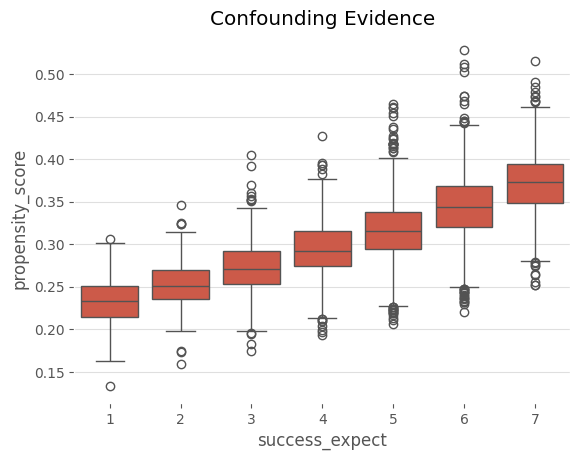

In [81]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

We also have to check that there is overlap between the treated and untreated population. To do so, we can see the empirical distribution of the propensity score on the untreated and on the treated. Looking at the image below, we can see that no one has a propensity score of zero and that even in lower regions of the propensity score we can find both treated and untreated individuals. This is what we call a nicely balanced treated and untreated population. 

In [82]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Finally, we can use our propensity score weighting estimator to estimate the average treatment effect. 

In [83]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.2598102884545834
Y0: -0.1290305288557172
ATE 0.3888408173103006


Propensity score weighting is saying that we should expect treated individuals to be 0.38 standard deviations above their untreated fellows, in terms of achievements. We can also see that if no one got the treatment, we should expect the general level of achievements to be 0.12 standard deviation lower than what it is now. By the same reasoning, we should expect the general level of achievement to be 0.25 standards deviation higher if we've given everyone the seminar. Contrast this to the 0.47 ATE estimate we've got by simply comparing treated and untreated. This is evidence that the bias we have is indeed positive and that controlling for X gives us a more modest estimate of the impact of the growth mindset.

## Standard Error
To compute the standard error for the IPTW estimator, we can use the formula of the variance of a weighted average.

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

However, we can only use this if we have the true propensity score. If we are using the estimated version of it, $\hat{P}(x)$, we need to account for the errors in this estimation process. The easiest way of doing this is by bootstrapping the whole procedure. This is achieved by sampling with replacement from the original data and computing the ATE like we did above. We then repeat this many times to get the distribution of the ATE estimate.

In [84]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Cellar/jupyterlab/4.4.3/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

The ATE is then the mean of the bootstrap samples. To get confidence intervals, we can inspect the quantiles of the bootstrap distribution. For the 95% C.I., we use the 2.5 and 97.5 percentiles.

In [85]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877398424521463
95% C.I.: (np.float64(0.35441382331743904), np.float64(0.4197524732102227))


We can also have a visual on what the bootstrap samples look like, along with the confidence intervals.

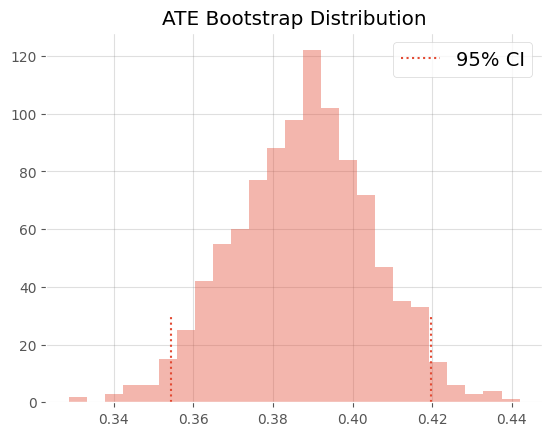

In [86]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Common Issues with Propensity Score

As a data scientist, I know it can be tempting to use all the power of the machine learning toolkit to make propensity score estimation as precise as possible. You can quickly get taken away by the all AUC optimisation, cross validation and bayesian hyper-parameter tuning. Now, I'm not saying you shouldn't do that. In fact, all of the theory about propensity score and machine learning is very recent, so there are lots we don't know yet. But it pays to understand something first. 

The first thing is that the predictive quality of the propensity score does not translate into its balancing properties. Coming from the field of machine learning, one of the most challenging aspects of getting acquainted with causal inference is letting go of treating everything as a prediction problem. In fact, maximising the prediction power of the propensity score can even hurt the causal inference goal. **Propensity score doesn't need to predict the treatment very well. It just needs to include all the confounding variables**. If we include variables that are very good in predicting the treatment but have no bearing on the outcome this will actually increase the variance of the propensity score estimator. This is similar to the problem linear regression faces when we include variables correlated with the treatment but not with the outcome. 

To see this, consider the following example (adapted from Hern√°n's Book). You have 2 schools, one of them apply the growth mindset seminar to 99% of its students and the other to 1%. Suppose that the schools have no impact on the treatment effect (except through the treatment), so it's not necessary to control for it. If you add the school variable to the propensity score model, it's going to have a very high predictive power. However, by chance, we could end up with a sample where everyone in school A got the treatment, leading to a propensity score of 1 for that school, which would lead to an infinite variance. This is an extreme example, but let's see how it would work with simulated data.

In [87]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

T  school  intercept         y
0  1       0          1  0.309526
1  1       0          1  1.571468
2  1       0          1  2.982024
3  1       0          1  2.445420
4  1       0          1  2.693187

Having simulated this data, we run bootstrap with the Propensity Score algorithm twice. The first including school as a feature to the propensity score model. The second time, we don't include school in the model.

In [88]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

In [89]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

As you can see, the propensity score estimator that adds the feature school has a humongous variance, while the one without it is much more well behaved. Also, since school is not a confounder, the model without it is also not biased. As I've said, simply predicting the treatment is not what this is about. We actually need to construct the prediction in a way that controls for confounding, not in a way to predict the treatment. 

This leads to another problem often encountered in propensity score methods. In our mindset case, the data turned out to be very balanced. But this is not always the case. In some situations, the treated have a much higher probability of treatment than the untreated and the propensity score distribution doesn't overlap much.

In [90]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

If this happens, it means that positivity is not very strong. If a treated has a propensity score of, say, 0.9 and the maximum propensity score of the untreated is 0.7, we won't have any untreated to compare to the individual with the 0.9 propensity score. This lack of balancing can generate some bias, because we will have to extrapolate the treatment effect to unknown regions. Not only that, entities with very high or very low propensity scores have a very high weight, which increases variance. As a general rule of thumb, you are in trouble if any weight is higher than 20 (which happens with an untreated with propensity score of 0.95 or a treated with a propensity score of 0.05). 

An alternative is clipping the weight to be at a maximum size of 20. This will decrease the variance, but it will actually generate more bias. To be honest, although this is a common practice to reduce variance, I don't really like it. You will never know if the bias you are inducing with clipping is too much. Also, if the distributions don't overlap, your data is probably not enough to make a causal conclusion anyway. To gain some further intuition about this, we can look at a technique that combines propensity score and matching

## Propensity Score Matching

As I've said before, you don't need to control for X when you have the propensity score. It suffices to control for it. As such, you can think of the propensity score as performing a kind of dimensionality reduction on the feature space. It condenses all the features in X into a single treatment assignment dimension. For this reason, we can treat the propensity score as an input feature for other models. Take a regression, model for instance.

In [91]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

If we control for the propensity score, we now estimate a ATE of 0.39, which is lower than the 0.47 we got previously with a regression model without controlling for the propensity score. We can also use matching on the propensity score. This time, instead of trying to find matches that are similar in all the X features, we can find matches that just have the same propensity score.

This is a huge improvement on top of the matching estimator, since it deals with the curse of dimensionality. Also, if a feature is unimportant for the treatment assignment, the propensity score model will learn that and give low importance to it when fitting the treatment mechanism. Matching on the features, on the other hand, would still try to find matches where individuals are similar on this unimportant feature.

In [92]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.383      0.025     15.252      0.000      0.334      0.432
           ATC      0.371      0.028     13.434      0.000      0.317      0.425
           ATT      0.407      0.027     15.341      0.000      0.355      0.459



As we can see, we also get an ATE of 0.38, which is more in line with what we've seen before with propensity score weighting. Matching on the propensity score also gives us some intuition about why it is dangerous to have a small overlap in the propensity score between treated and untreated. If this happens, the matching on the propensity score discrepancy will be large, which will lead to bias, as we've seen on the matching chapter. 

One final word of caution here is that the above standard errors are wrong, as they don't account for the uncertainty in the estimation of the propensity score. Unfortunately, [bootstrap doesn't work with matching](https://economics.mit.edu/files/11862). Also, the theory above is so recent that there are no Python implementations of propensity score methods with the correct standard errors. For this reason, we don't see a lot of propensity score matching in Python. 

## Key Ideas

Here, we've learned that the probability of getting the treatment is called the propensity score and that we can use this as a balancing score. What this means is that, if we have the propensity score, we don't need to control for the confounders directly. It is sufficient to control for the propensity score in order to identify the causal effect. We saw how the propensity scores acts as a dimensionality reduction on the confounder space.

These properties allowed us to derive a weighting estimator for causal inference. Not only that, we saw how the propensity score can be used along other methods to control for confounding bias. 

Then, we looked at some common issues that can arise with propensity score and with causal inference in general. The first one is when we  get carried away by the task of fitting the treatment mechanism. We saw that, in a very counterintuitive (and hence easy to get it wrong) way, increasing the predictive performance of the treatment does **not** translate into a better causal estimate, as it can increase variance.

Finally, we looked at some extrapolation problems that we might run into if we are unable to have a good overlap between the treated and untreated propensity score distribution. 

## <a id = "p4">4.</a>  <font color = "green"> What We Learned & What's Next </font>  [back to table of contents](#top)

> In our Lesson 4, we learned about two econometric methods for causal inference‚Äîhow to answer causal analytic questions in the field when randomized controlled trials (RCTs) are not feasible for data collection. Let me further remind you of specific examples of how instrumental variables (IV) can be used in the fields of finance and real estate to address endogeneity issues and provide more accurate causal estimates.

## The Use Cases of Propensity Score Matching (PSM)

### Finance in General

#### Case 1: Evaluating the Impact of Financial Literacy Programs on Investment Behavior

* Context: Financial literacy programs aim to improve individuals' understanding of financial concepts and, consequently, their investment behavior. However, participants in these programs might differ systematically from non-participants in ways that also affect investment behavior, leading to selection bias.

* Application: To evaluate the impact of financial literacy programs on investment behavior, PSM can be used to match individuals who participated in the program with similar individuals who did not, based on observed characteristics such as age, income, education, and prior financial knowledge. By comparing the investment behavior of matched participants and non-participants, we can estimate the causal effect of the financial literacy program while controlling for selection bias.

#### Case 2: Assessing the Effect of Corporate Social Responsibility (CSR) on Firm Performance

* Context: Firms that engage in CSR activities may experience enhanced firm performance due to improved reputation and customer loyalty. However, firms that choose to engage in CSR may already differ from those that do not, in ways that could affect performance.

* Application: PSM can be used to assess the effect of CSR on firm performance by matching firms that engage in CSR activities with similar firms that do not, based on characteristics such as industry, firm size, profitability, and market conditions. This matching process helps create a balanced sample, allowing for a more accurate estimation of the causal effect of CSR on firm performance.

### Real Estate

#### Case 1: Estimating the Impact of Affordable Housing Programs on Neighborhood Property Values

* Context: Affordable housing programs are designed to provide housing for low-income families, but their impact on surrounding property values is often debated. Selection bias can arise because neighborhoods chosen for affordable housing projects might already have different trends in property values compared to other neighborhoods.

* Application: PSM can be used to estimate the impact of affordable housing programs on neighborhood property values by matching neighborhoods with affordable housing projects to similar neighborhoods without such projects, based on pre-existing characteristics like median income, crime rates, school quality, and distance to amenities. By comparing property values in matched neighborhoods, we can isolate the effect of affordable housing programs on local property values.

#### Case 2: Analyzing the Effect of Homeowner Education Programs on Mortgage Default Rates

* Context: Homeowner education programs aim to reduce mortgage default rates by improving borrowers' financial management skills. However, individuals who choose to participate in these programs may differ from those who do not, in ways that influence their likelihood of default.

* Application: To analyze the effect of homeowner education programs on mortgage default rates, PSM can be used to match participants of the education programs with non-participants based on characteristics such as credit scores, income, loan-to-value ratios, and employment status. This matching process helps control for selection bias, enabling a more accurate estimation of the program's effect on mortgage default rates.

> In both finance and real estate, instrumental variables provide a robust method for overcoming endogeneity and identifying causal relationships. By carefully selecting appropriate instruments, researchers and practitioners can obtain more reliable estimates that inform policy decisions, investment strategies, and market analyses, ultimately leading to better outcomes in these fields.

> I hope you have a chance to revisit what you have learned from the lessons and lecture notes. It is always good practice to take time for revision and make notes of your key learning points in your own words. Use this section below as your revision guide.

    REVISION NOTE

    - Revision pointer A

    - Revision pointer B

    - Revision pointer C

> `Thank you for working with the script, Team üëç`